# Image deconvolution

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import logging
logger = logging.getLogger()
np.random.seed(40)

In [2]:
from tramp.models import DAGModel, MultiLayerModel
from tramp.base import SISOVariable, SIMOVariable, MILeafVariable
from tramp.likelihoods import GaussianLikelihood
from tramp.channels import DFTChannel, Blur2DChannel, GradientChannel, GaussianChannel
from tramp.priors import GaussBernouilliPrior, BinaryPrior, GaussianPrior
from tramp.algos import ExpectationPropagation, StateEvolution, TrackEvolution, EarlyStopping, JoinCallback

In [3]:
plt.rc("text", usetex=True)
logger.setLevel(logging.INFO)

In [4]:
def square_blob(shape, x, y):
    g = np.zeros(shape)
    g[x[0]:x[1], y[0]:y[1]] = 1.
    return g

def plot_data():
    fig, axs = plt.subplots(1,3,figsize=(8,3))
    axs[0].imshow(x, cmap="gray")
    axs[0].set(title=r"$x$")
    axs[1].imshow(x_blur, cmap="gray")
    axs[1].set(title=r"$g\ast x$")
    axs[2].imshow(y, cmap="gray")
    axs[2].set(title=r"$y$")
    fig.tight_layout()

def plot_prediction(r_pred):
    fig, axs = plt.subplots(1,2,figsize=(6, 3))
    axs[0].imshow(r_pred["x"], cmap="gray")
    axs[0].set(title=r"$x$")
    axs[1].imshow(r_pred["z"], cmap="gray")
    axs[1].set(title=r"$g\ast x$")
    fig.tight_layout()
    
def compare_prediction(r_pred, u1=20):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=False)
    axs[0].plot(x[:,u1], label="true")
    axs[0].plot(r_pred["x"][:,u1], label="pred")
    axs[0].legend()
    axs[0].set(title=r"$x$")
    axs[1].plot(x_blur[:,u1], label="true")
    axs[1].plot(r_pred["z"][:,u1], label="pred")
    axs[1].legend()
    axs[1].set(title=r"$g\ast x$")
    fig.tight_layout()
    
def run_model(model):
    logger.setLevel(logging.INFO)
    callback = EarlyStopping(tol=1e-6, min_variance=1e-15)
    ep = ExpectationPropagation(model)
    ep.iterate(max_iter=30, callback=callback)
    r_pred = {x_id: data["r"] for x_id, data in ep.get_variables_data().items()}
    v_pred = {x_id: data["v"] for x_id, data in ep.get_variables_data().items()}
    x_mse = mean_squared_error(x, r_pred["x"])  
    print(f"n_iter={ep.n_iter}")
    print(f"v_pred={v_pred}")
    print(f"x_mse={x_mse}")
    plot_prediction(r_pred)
    compare_prediction(r_pred)

In [5]:
sblob = square_blob(
    (40, 50), x=(5, 10), y=(10, 15)
) + square_blob(
    (40, 50), x=(5, 15), y=(20, 40)
) + square_blob(
    (40, 50), x=(20, 35), y=(15, 45)
)

# signal 
s_blur = 3
x = 2*sblob - 1
x_shape = np.shape(x)
p_pos = (x==1).mean()
p_neg = (x==-1).mean()
print(f"p_pos={p_pos} p_neg={p_neg}")
# blurring
blur = Blur2DChannel(sigma=[s_blur, s_blur], shape=x_shape)
x_blur = blur.convolve(x)

p_pos=0.3375 p_neg=0.6625


## Binary image deconv (noiseless)

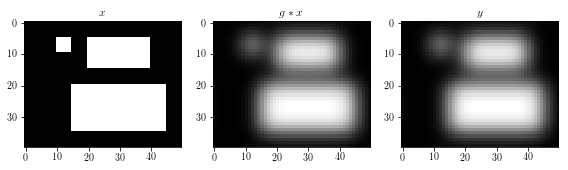

In [6]:
var_noise = 1e-6
y = x_blur + np.sqrt(var_noise)*np.random.standard_normal(x_shape)
plot_data()

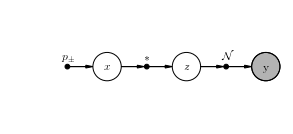

In [7]:
# binary deconv model
prior = BinaryPrior(size=x_shape, p_pos=p_pos)
noise = GaussianChannel(var=var_noise)
binary_deconv = MultiLayerModel(
    [prior, blur, noise], ids=["x","z","y"]
).to_observed({"y":y})
binary_deconv.daft()

INFO:root:init message dag with ConstantInit(a=0,b=0)
INFO:root:early stopping: min variance 1e-20
INFO:root:terminated after n_iter=7 iterations


n_iter=7
v_pred={'x': 9.9999999999999995e-21, 'z': 9.9999999999999995e-21}
x_mse=1.0474593707137747e-31


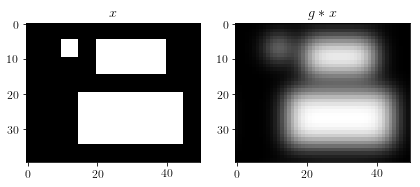

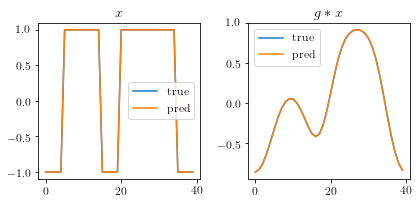

In [8]:
run_model(binary_deconv)

## Binary image deconv (noisy)

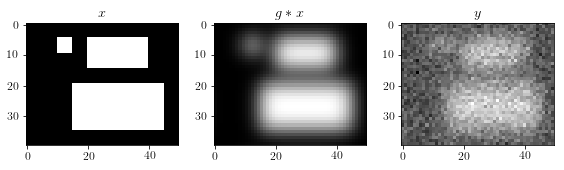

In [9]:
var_noise = 0.1
y = x_blur + np.sqrt(var_noise)*np.random.standard_normal(x_shape)
plot_data()

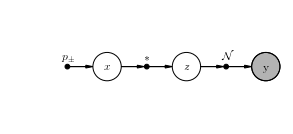

In [10]:
noise = GaussianChannel(var=var_noise)
binary_deconv_noisy = MultiLayerModel(
    [prior, blur, noise], ids=["x","z","y"]
).to_observed({"y":y})
binary_deconv_noisy.daft()

INFO:root:init message dag with ConstantInit(a=0,b=0)
INFO:root:early stopping: all tolerances are below tol=1.00e-06
INFO:root:terminated after n_iter=18 iterations


n_iter=18
v_pred={'x': 0.4674115093260463, 'z': 0.0015462547180434103}
x_mse=0.20087517985686662


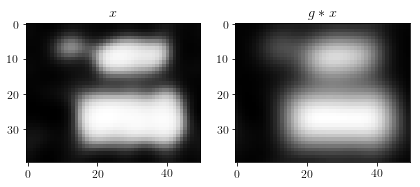

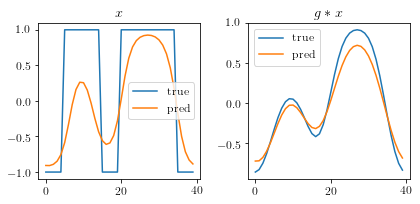

In [11]:
run_model(binary_deconv_noisy)